In [1]:
from itertools import product
from collections import Counter

from numpy import inf,sum,gradient,pi,argsort,array,argmax,sqrt,sort,exp,amin,amax,less,greater,linspace,argmin,histogram,isclose,mean,diff
from sklearn import mixture
from scipy.signal import argrelextrema

from matplotlib.pyplot import plot,figure,show,axvline,fill_between,twinx
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from numpy import ones,quantile,median,log,sign,ndenumerate,array,median,nan,isnan,arcsinh,unique,mean,dot,argmin,argmax,std,einsum,eye,linspace,amin,amax,exp,less,gradient,abs
from pandas import DataFrame,Series

from matplotlib.collections import PolyCollection
from matplotlib.pyplot import close,savefig,hist,plot,title,figure,subplot,figlegend,xticks,yticks,axis,xticks,yticks,axhline
from matplotlib.pyplot import axvline,matshow,xlabel,ylabel,ylim,xlim,tight_layout,yscale,fill_between,setp,scatter
from matplotlib.ticker import MultipleLocator

from seaborn import swarmplot,boxplot,violinplot,color_palette,pairplot
from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler( color=[ '#%02x%02x%02x'%tuple((255*array(color)).astype(int)) for color in color_palette('Set3') ] )

from scanpy import settings
settings.verbosity = 3
settings.set_figure_params(dpi=80, facecolor='white')
%matplotlib inline

ImportError: cannot import name 'plot_confusion_matrix'

In [3]:
from utils.workspace import Workspace
from re import search

from scanpy import AnnData
from scanpy.preprocessing import neighbors
from scanpy.tools import umap,leiden
from scanpy.plotting import umap as plot_umap

from matplotlib.pyplot import *
from matplotlib.collections import PolyCollection
from seaborn import violinplot,color_palette

from scanpy import settings
settings.verbosity = 3
settings.set_figure_params(dpi=80, facecolor='white')

from pandas import *
from numpy import *

from matplotlib import rcParams
from cycler import cycler
rcParams['axes.prop_cycle'] = cycler( color=[ '#%02x%02x%02x'%tuple((255*array(color)).astype(int)) for color in color_palette('Set3') ] )

######################################## channels
channels = {
    
    # laser channel to marker maps
    'FJComp-355 379_28-A': 'CD3', 
    'FJComp-355 560_40-A': 'CD8', 
    'FJComp-355 740_35-A': 'CD69', 
    'FJComp-355 820_60-A': 'CD4',
    'FJComp-355 670_30-A': 'CD4',
    'FJComp-405 450_50-A': 'CD103', 
    'FJComp-405 515_20-A': 'HLA-DR', 
    'FJComp-405 605_40-A': 'CCR4', 
    'FJComp-405 670_30-A': 'CCR6', 
    'FJComp-405 710_40-A': 'PD-1', 
    'FJComp-405 780_60-A': 'CD45RA', 
    'FJComp-488 525_50-A': 'CCR10', 
    'FJComp-488 715_30-A': 'CXCR3', 
    'FJComp-561 585_15-A': 'Foxp3', 
    'FJComp-561 610_20-A': 'Helios', 
    'FJComp-561 780_60-A': 'CD127', 
    'FJComp-640 670_30-A': 'CD25', 
    'FJComp-640 730_35-A': 'CXCR5', 
    'FJComp-640 780_60-A': 'CCR7',
    
    # renaming maps
    'Foxp3-IgM': 'Foxp3',
    'CD3-IgD':'CD3',
}

######################################## condition parser
def parser(file_path) :
    '''get tissue and patient id from filepath'''
    
    tissue = search('_(.+?)_',file_path).group()
    if 'Blood' in tissue : tissue = '_Blood_'

    patient = search('/[0-9]+C/',file_path).group()
    return {'patient':patient[1:-1],'tissue':tissue[1:-1]}


######################################### data import 
workspace = Workspace( 'data/workspace.wsp', thresholds = 'data/thresholds.csv',
                      channels = channels, condition_parser = parser)

file specified in workspace not found:
data/412C/412C_unst_022.cleaned.fcs
file specified in workspace not found:
data/423C/Donor_unst_037.cleaned.fcs
file specified in workspace not found:
data/390C/390C_unst_022.cleaned.fcs
file specified in workspace not found:
data/428C/Donor_unst_032.cleaned.fcs
file specified in workspace not found:
data/403C/donor_unst_021.cleaned.fcs


In [21]:
workspace.index.size

34

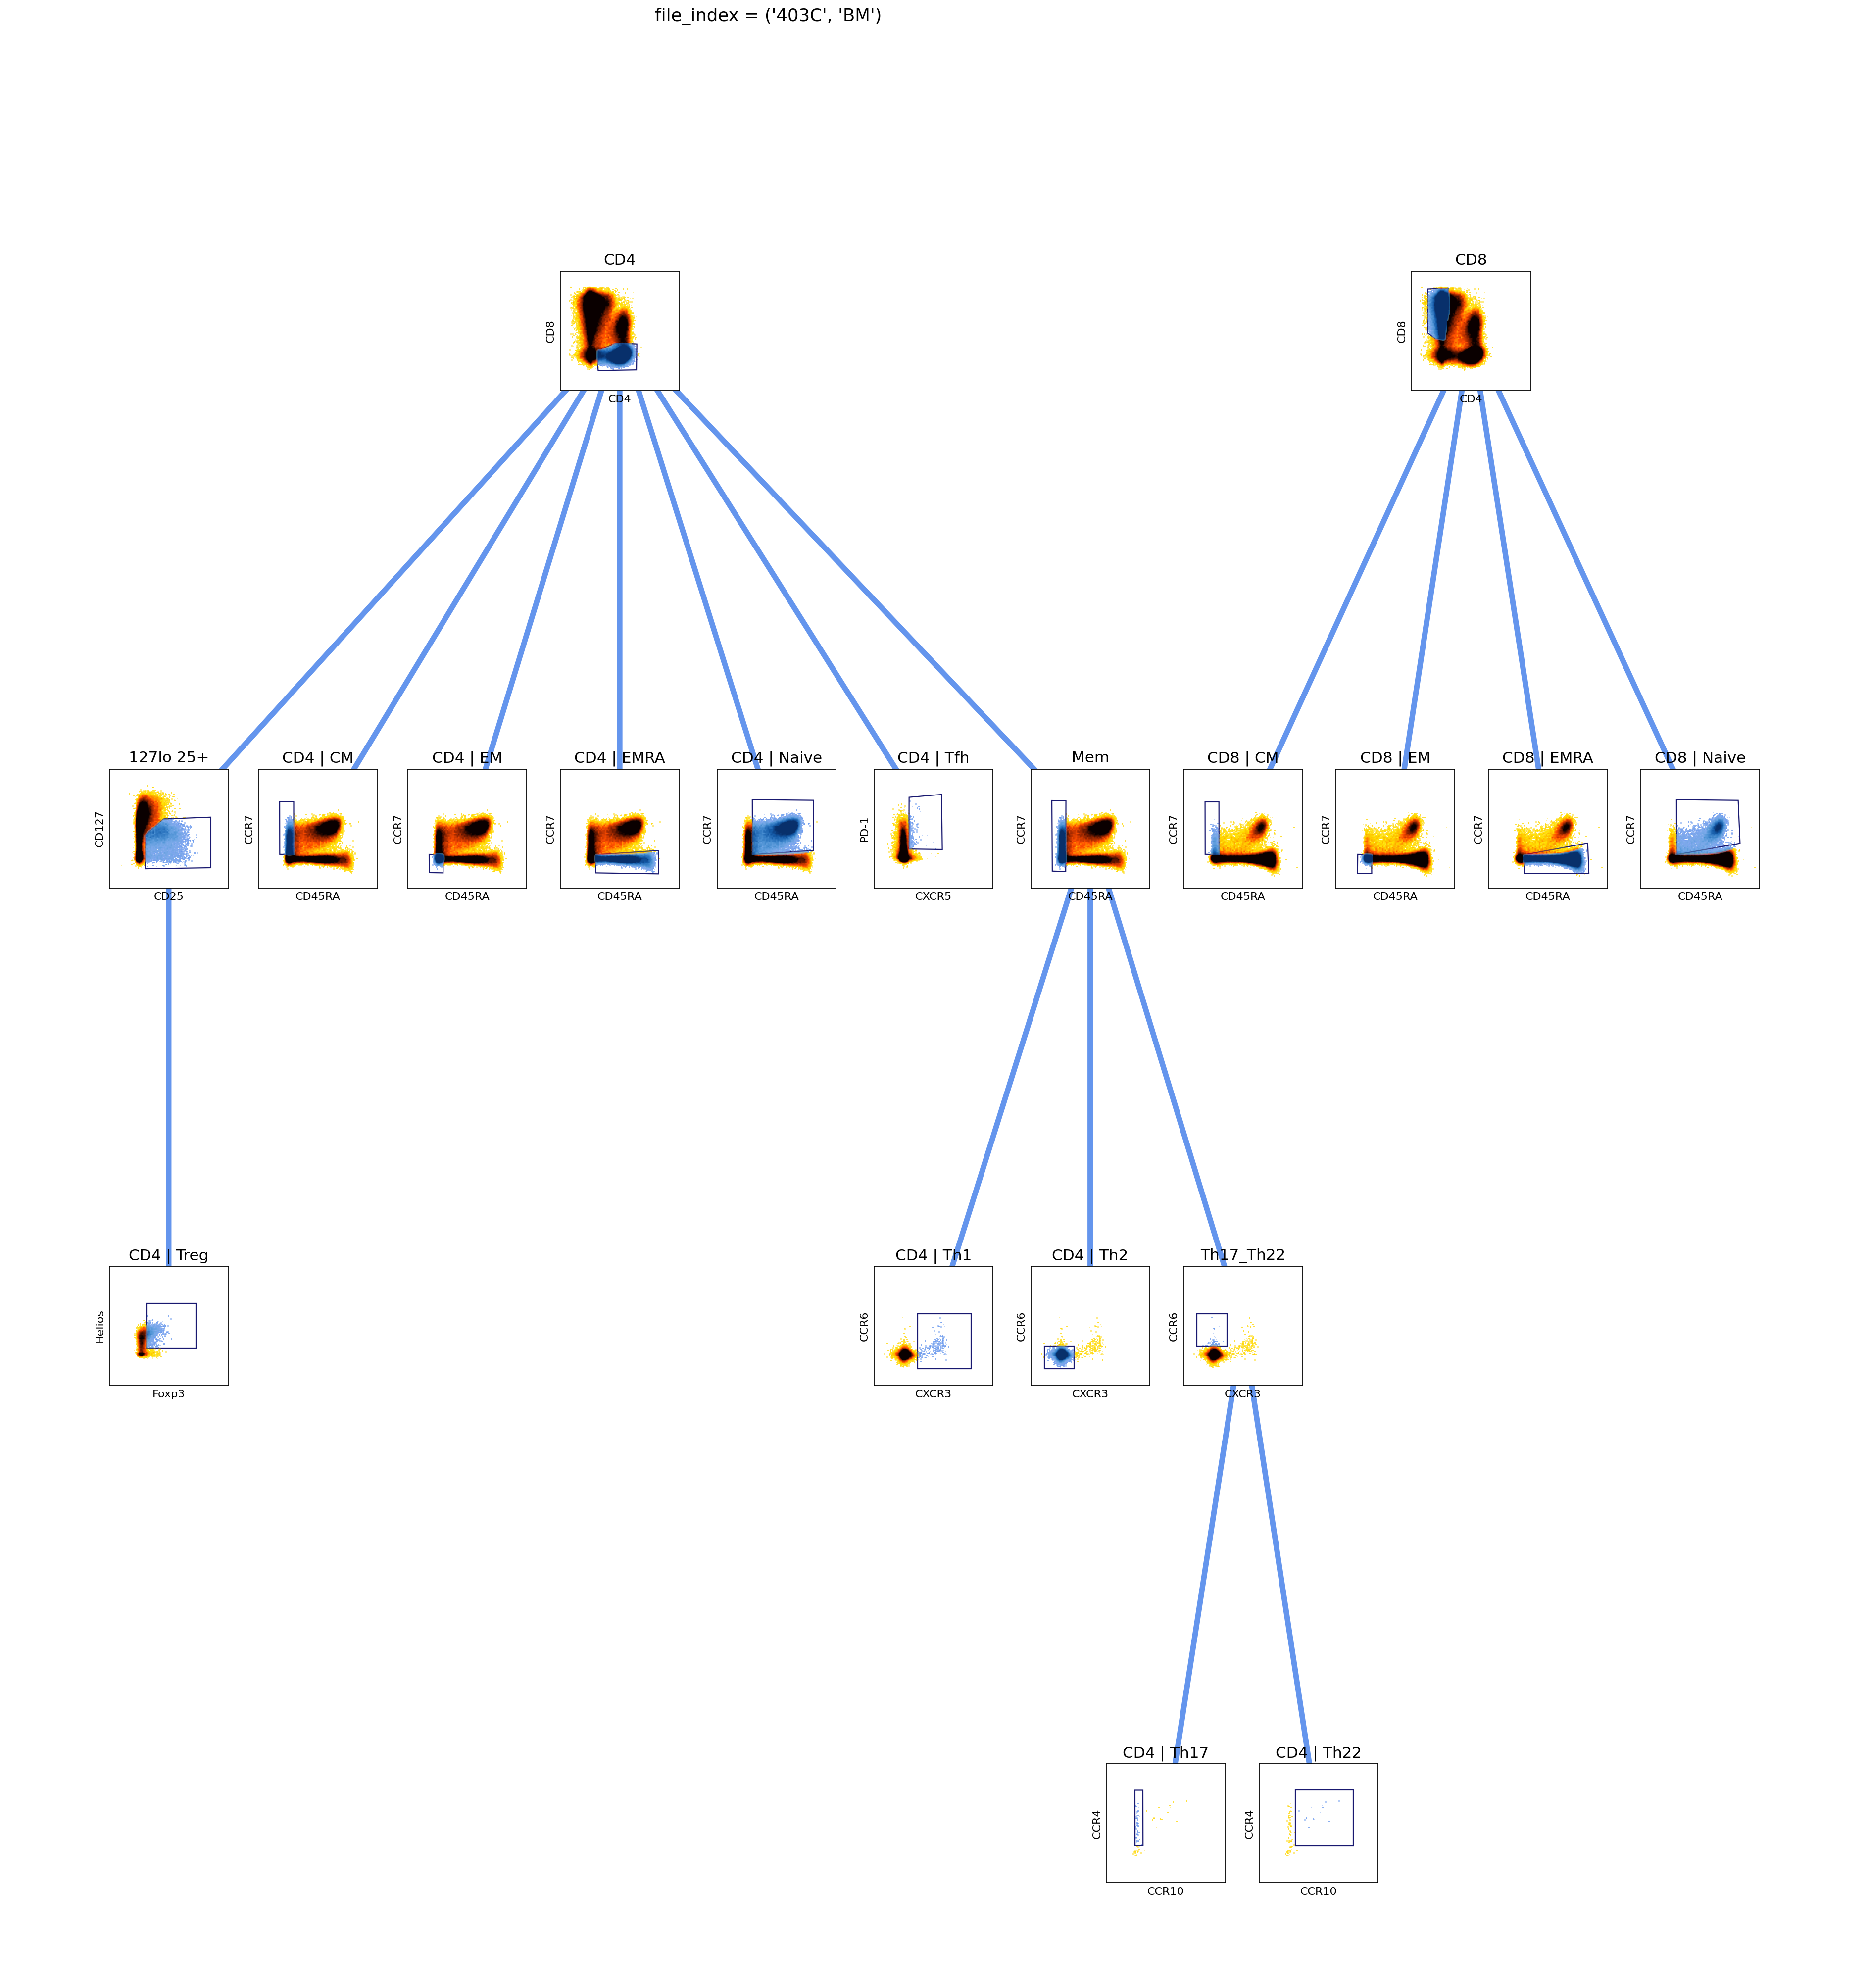

In [22]:
# show gating strategy for one file
workspace.show(('403C','BM'))

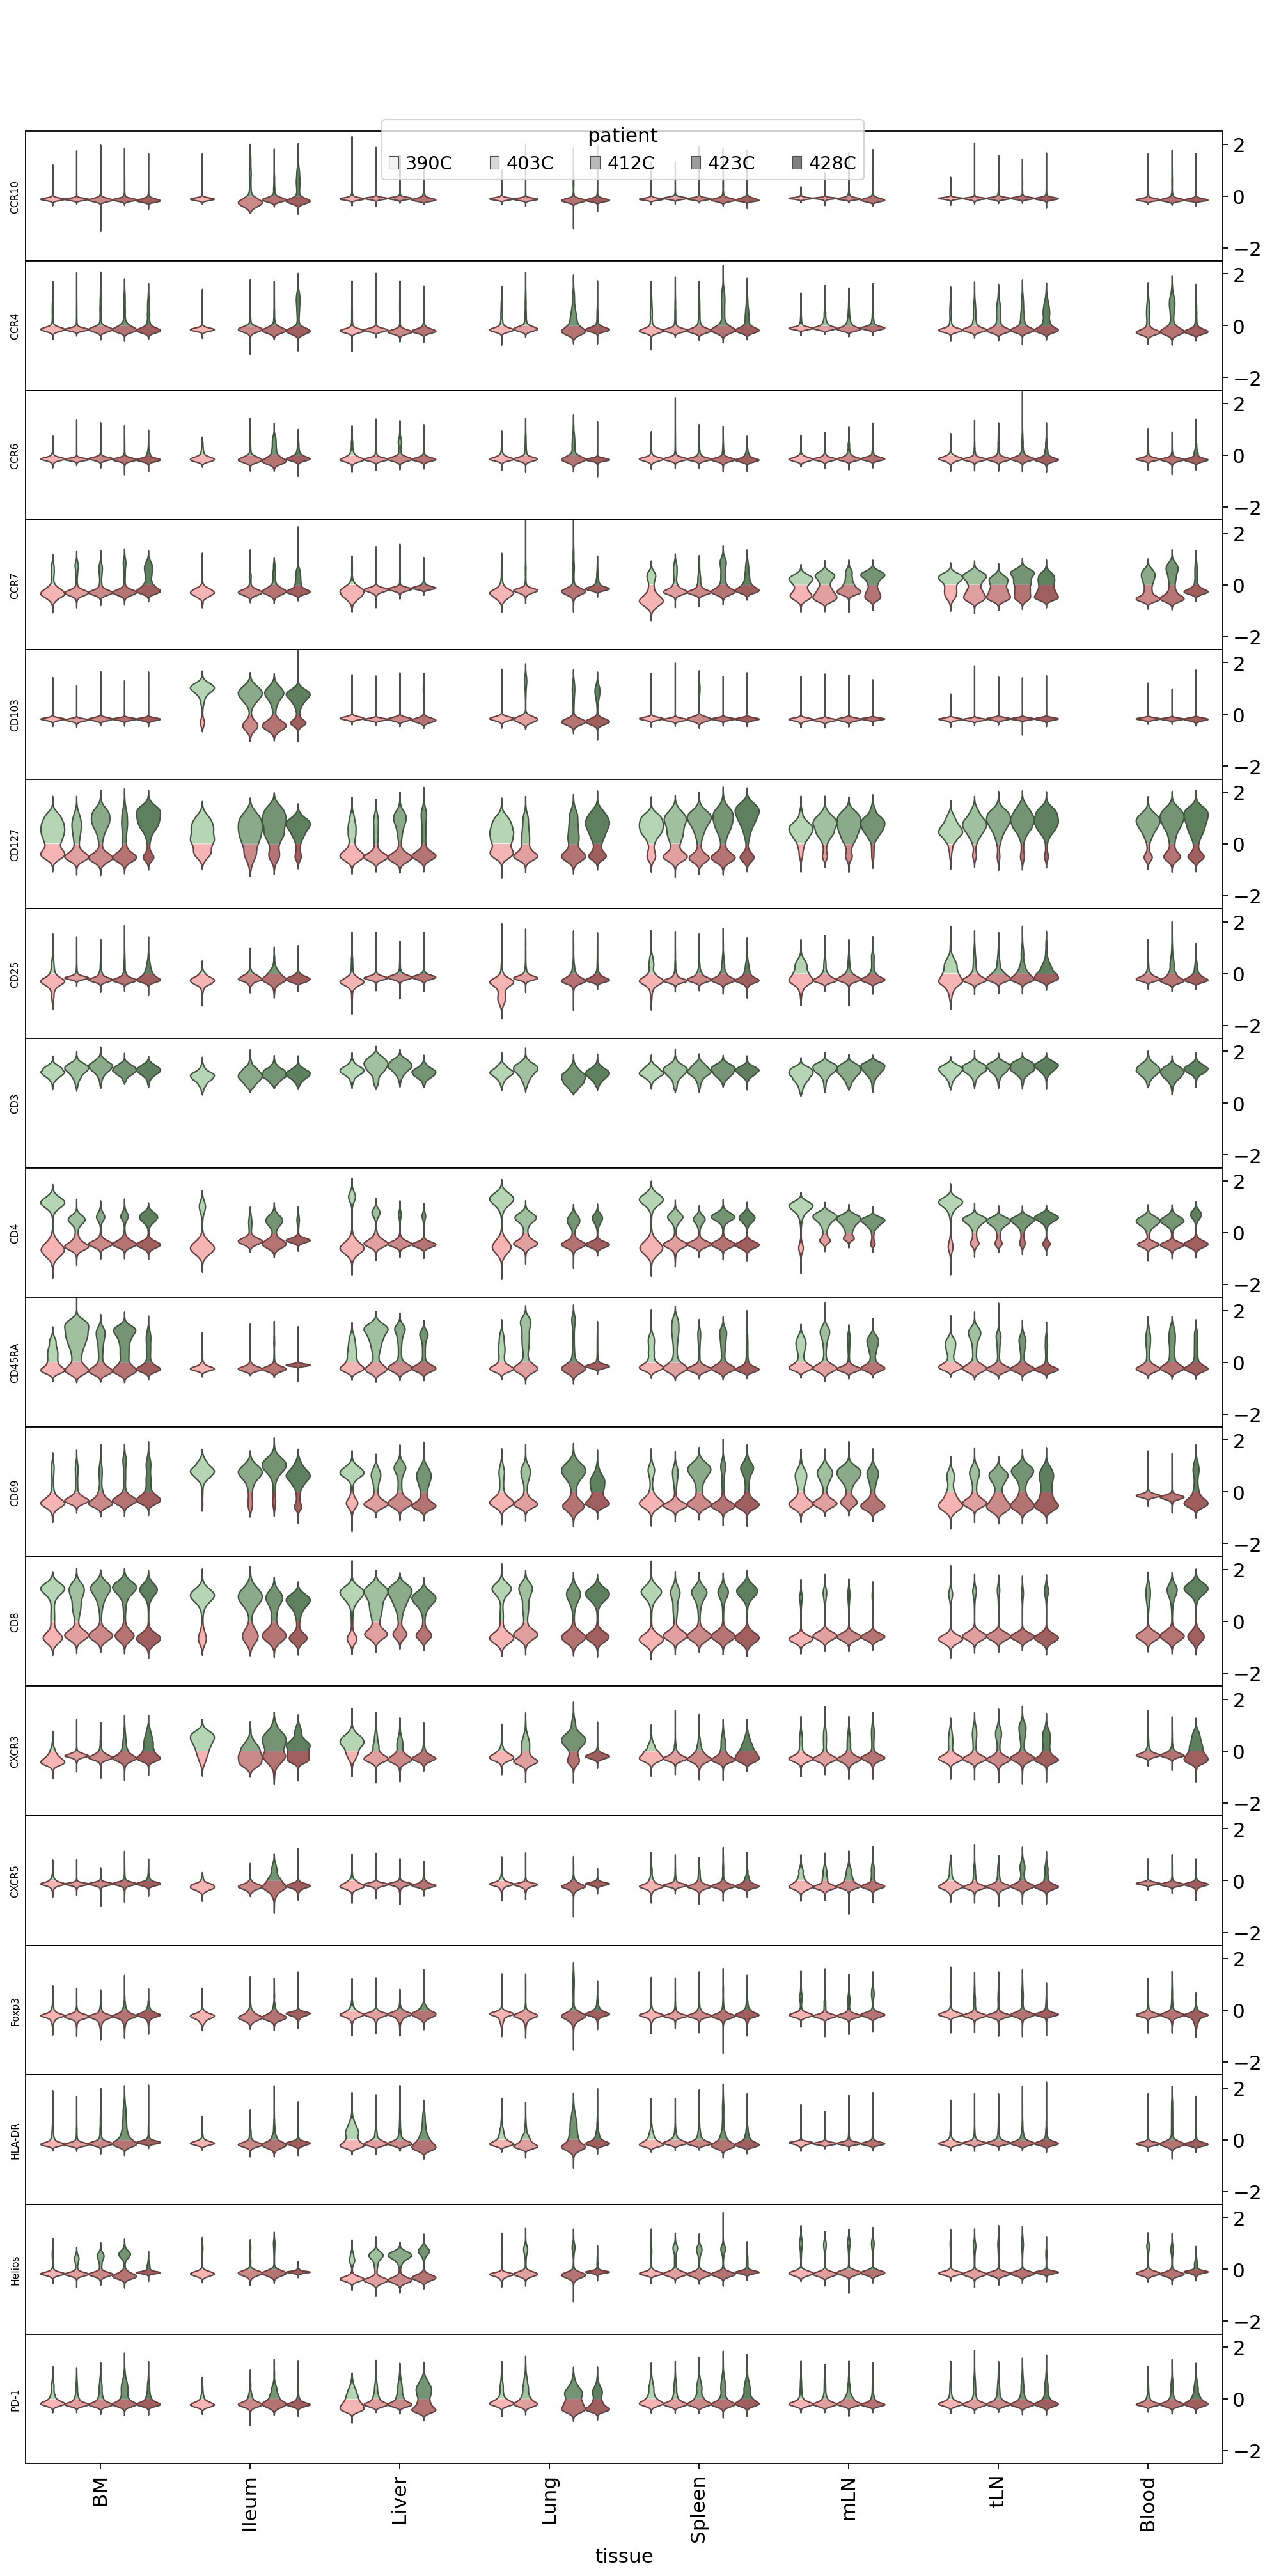

In [5]:
# show channel distributions to verify threshold locations
workspace.violinplot()

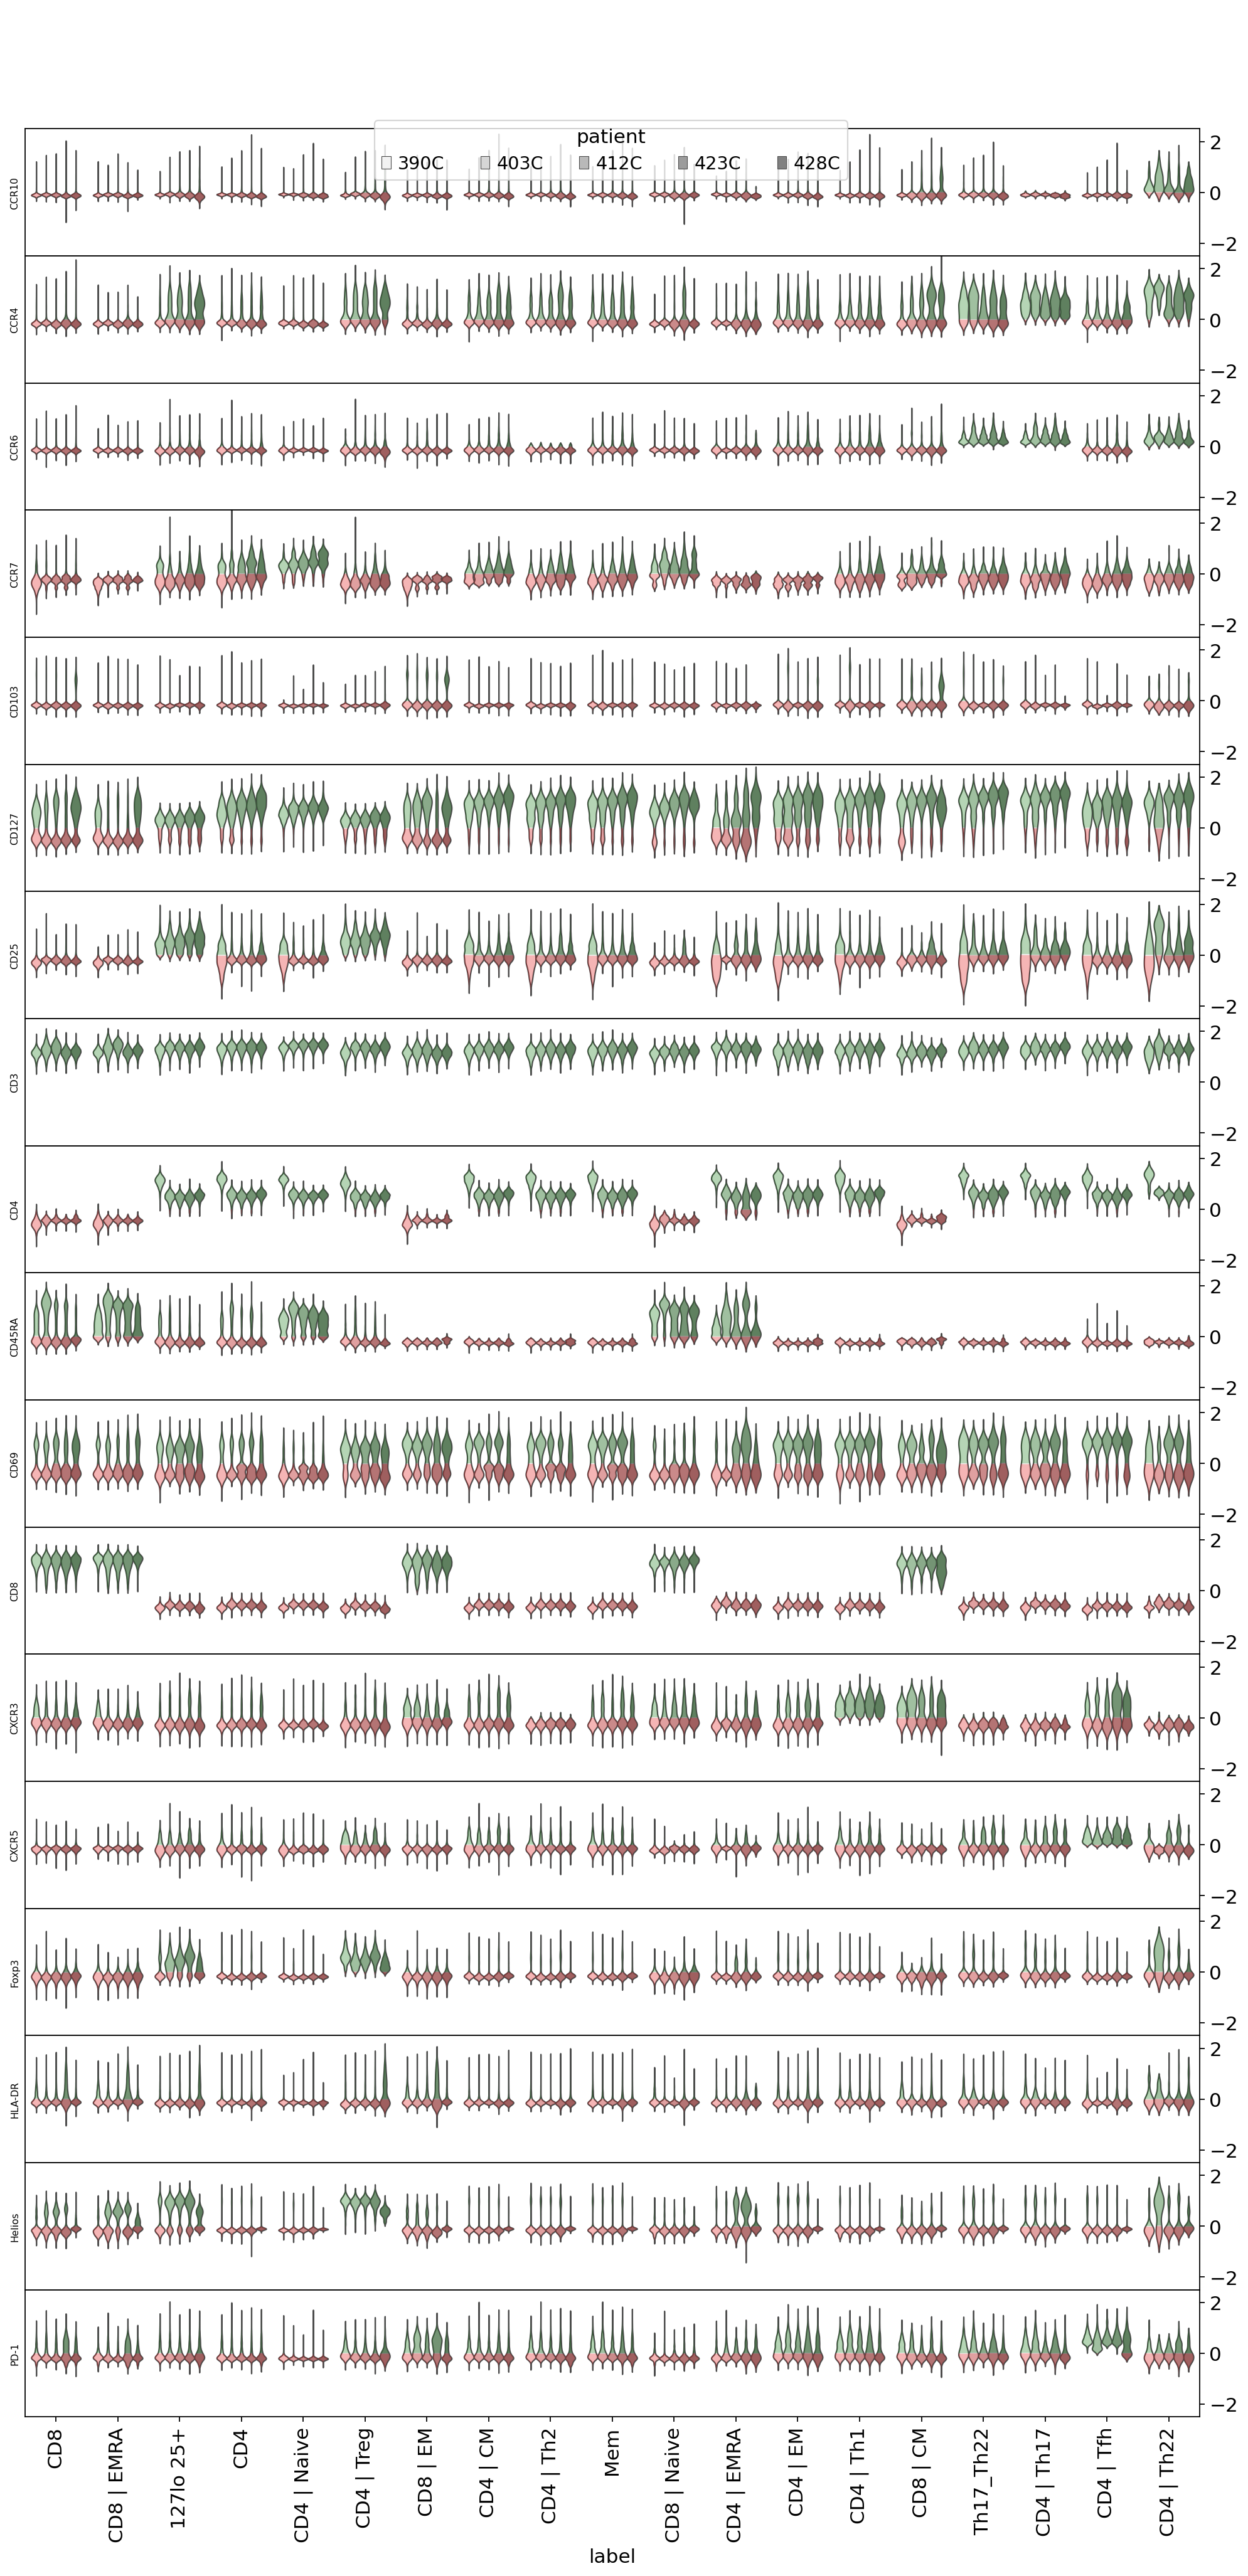

In [7]:
# verify accuracy labels from gating strategy 
workspace.violinplot(x='label')

In [8]:
################################################# extract features and labels
sample = workspace.sample(n=3000)
features = sample.data - workspace.thresholds
positive = features>0

sigma = features[positive].groupby(['patient','tissue']).std()
mu =    features[positive].groupby(['patient','tissue']).mean()
features[positive] = ( features[positive] - mu ) / sigma + 5

sigma = features[~positive].groupby(['patient','tissue']).std()
mu =    features[~positive].groupby(['patient','tissue']).mean()
features[~positive] = ( features[~positive] - mu ) / sigma - 5

# reorder columns
marker_order = [
       'CD3', 'CD8', 'CD4',
       'CCR7', 'CD45RA', 'CD127', 'CD25', 'Helios', 'Foxp3',
       'PD-1', 'CXCR5', 'CCR6', 'CXCR3', 'CCR4', 'CCR10',
       'CD103', 'CD69', 'HLA-DR'
]
features = features.reindex( columns=marker_order).sort_index()

# convert one-hot-encoding to multilabel; dropping intermediate gates
labels = sample.labels.drop(columns=['CD4','CD8','Mem','Th17_Th22','127lo 25+'])
labels = labels.melt(ignore_index=False,var_name='label')
labels = labels[labels.value].drop(columns='value').sort_index()

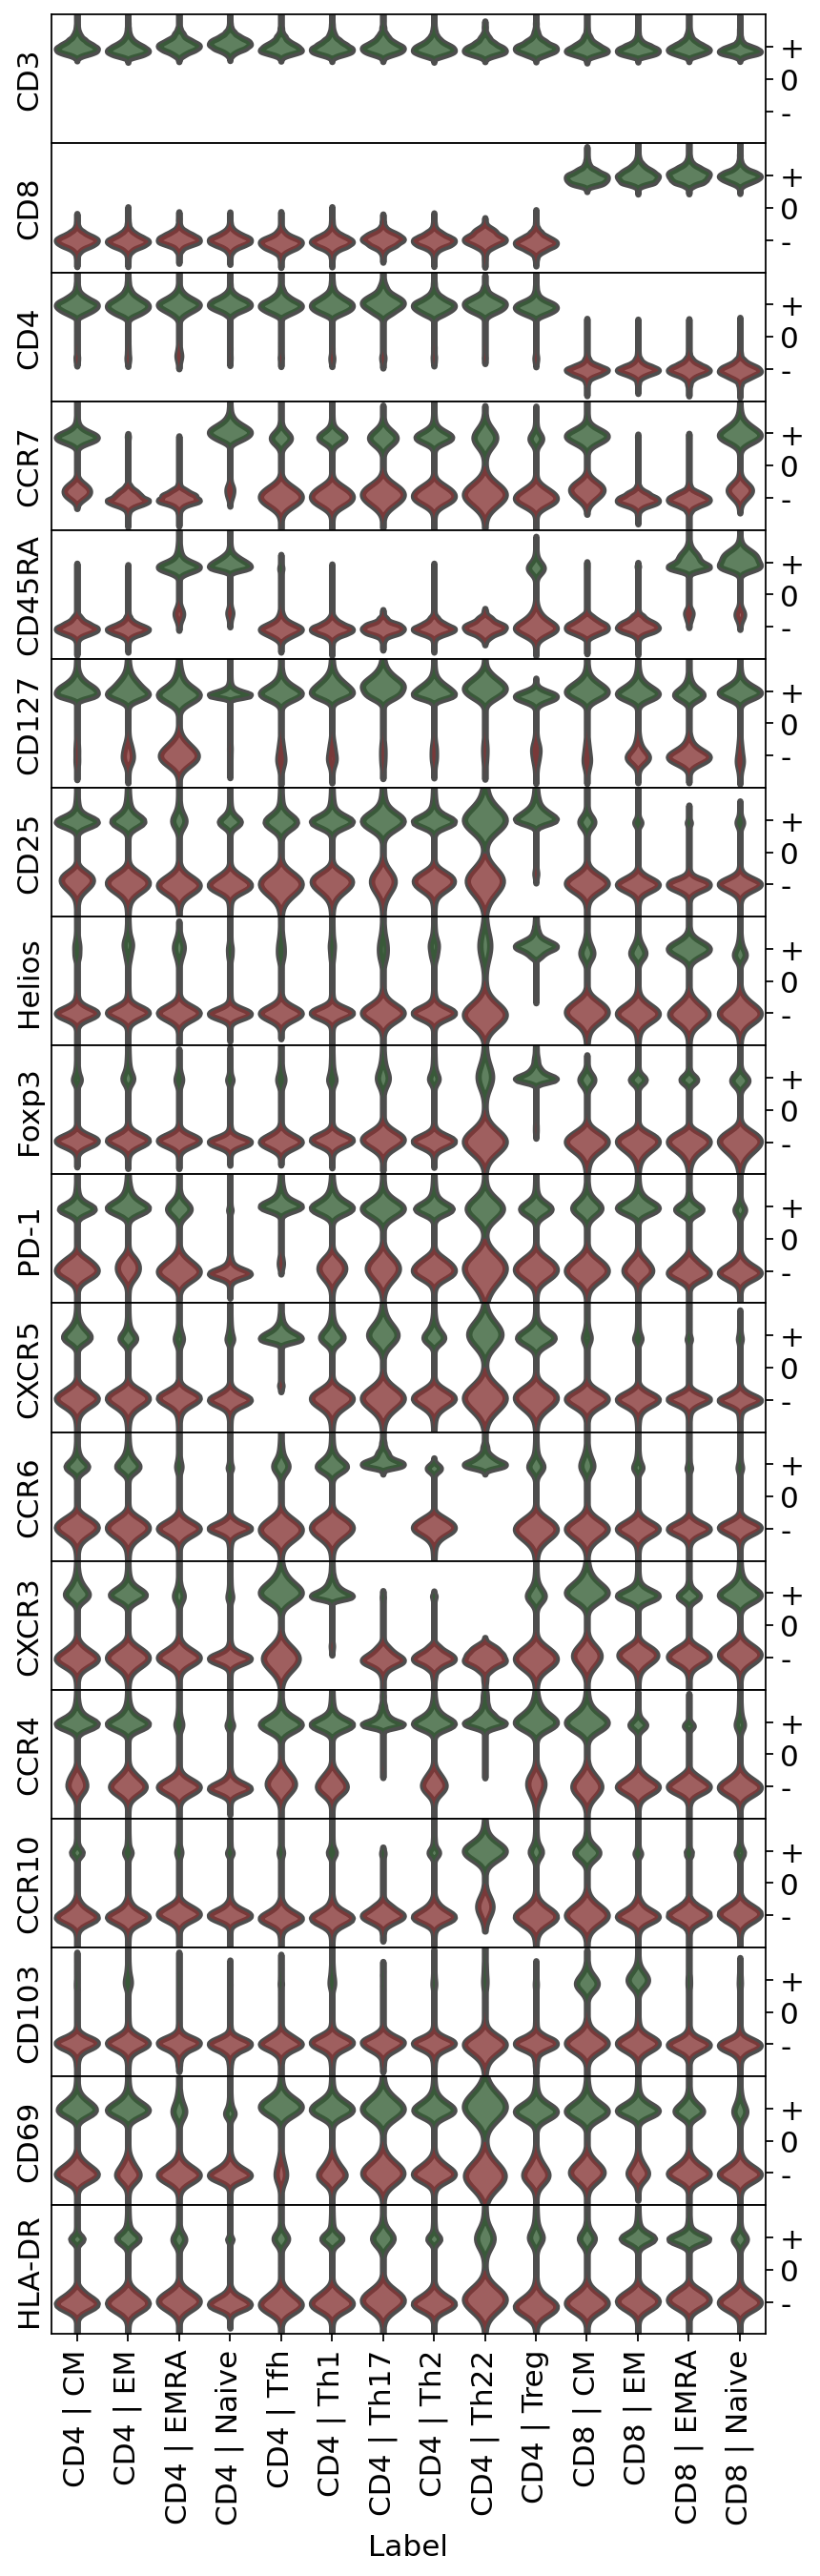

In [9]:
fig = figure(figsize=(6,20))
for i,channel in enumerate(features.columns) :
    ax = subplot(features.columns.size,1,i+1)
    
    violinplot(x='label', y=channel, data=labels.join(features), order=sort(labels.label.unique()),
               scale='width',inner=None, color='gray',linewidth=3, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    for element in ax.get_children():
        if isinstance(element,PolyCollection):
            path, = element.get_paths()
            
            try :
                vertices = path.vertices[path.vertices[:,1]>0]
                ax.add_collection(PolyCollection(vertices[None,...],facecolor='green',alpha=0.25))
            except :
                pass
            
            try :
                vertices = path.vertices[path.vertices[:,1]<0]
                ax.add_collection(PolyCollection(vertices[None,...],facecolor='red',alpha=0.25))
            except :
                pass
    
    ax.yaxis.tick_right()
    yticks([-5,0,5],['-',0,'+'])
    ylim(-10,10)

    xlabel('Label')
    ax.grid(False)

fig.subplots_adjust(hspace=0)
ax.get_shared_x_axes().join(*fig.axes)
setp([ ax.get_xticklabels() for ax in fig.axes[:-1]], visible=False);

In [10]:
dataset = AnnData( features.reset_index(drop=True),
                   obs = features.index.to_frame().reset_index(drop=True),
                   var = features.columns.to_frame().drop(columns=0) )

/home/gszep/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
################################################# dimensionality reduction
from warnings import filterwarnings
from numba import NumbaDeprecationWarning
filterwarnings('ignore', category=NumbaDeprecationWarning)

neighbors(dataset, n_neighbors=10, n_pcs=40)
umap(dataset)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:24)


/home/gszep/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'patient' as categorical
... storing 'tissue' as categorical


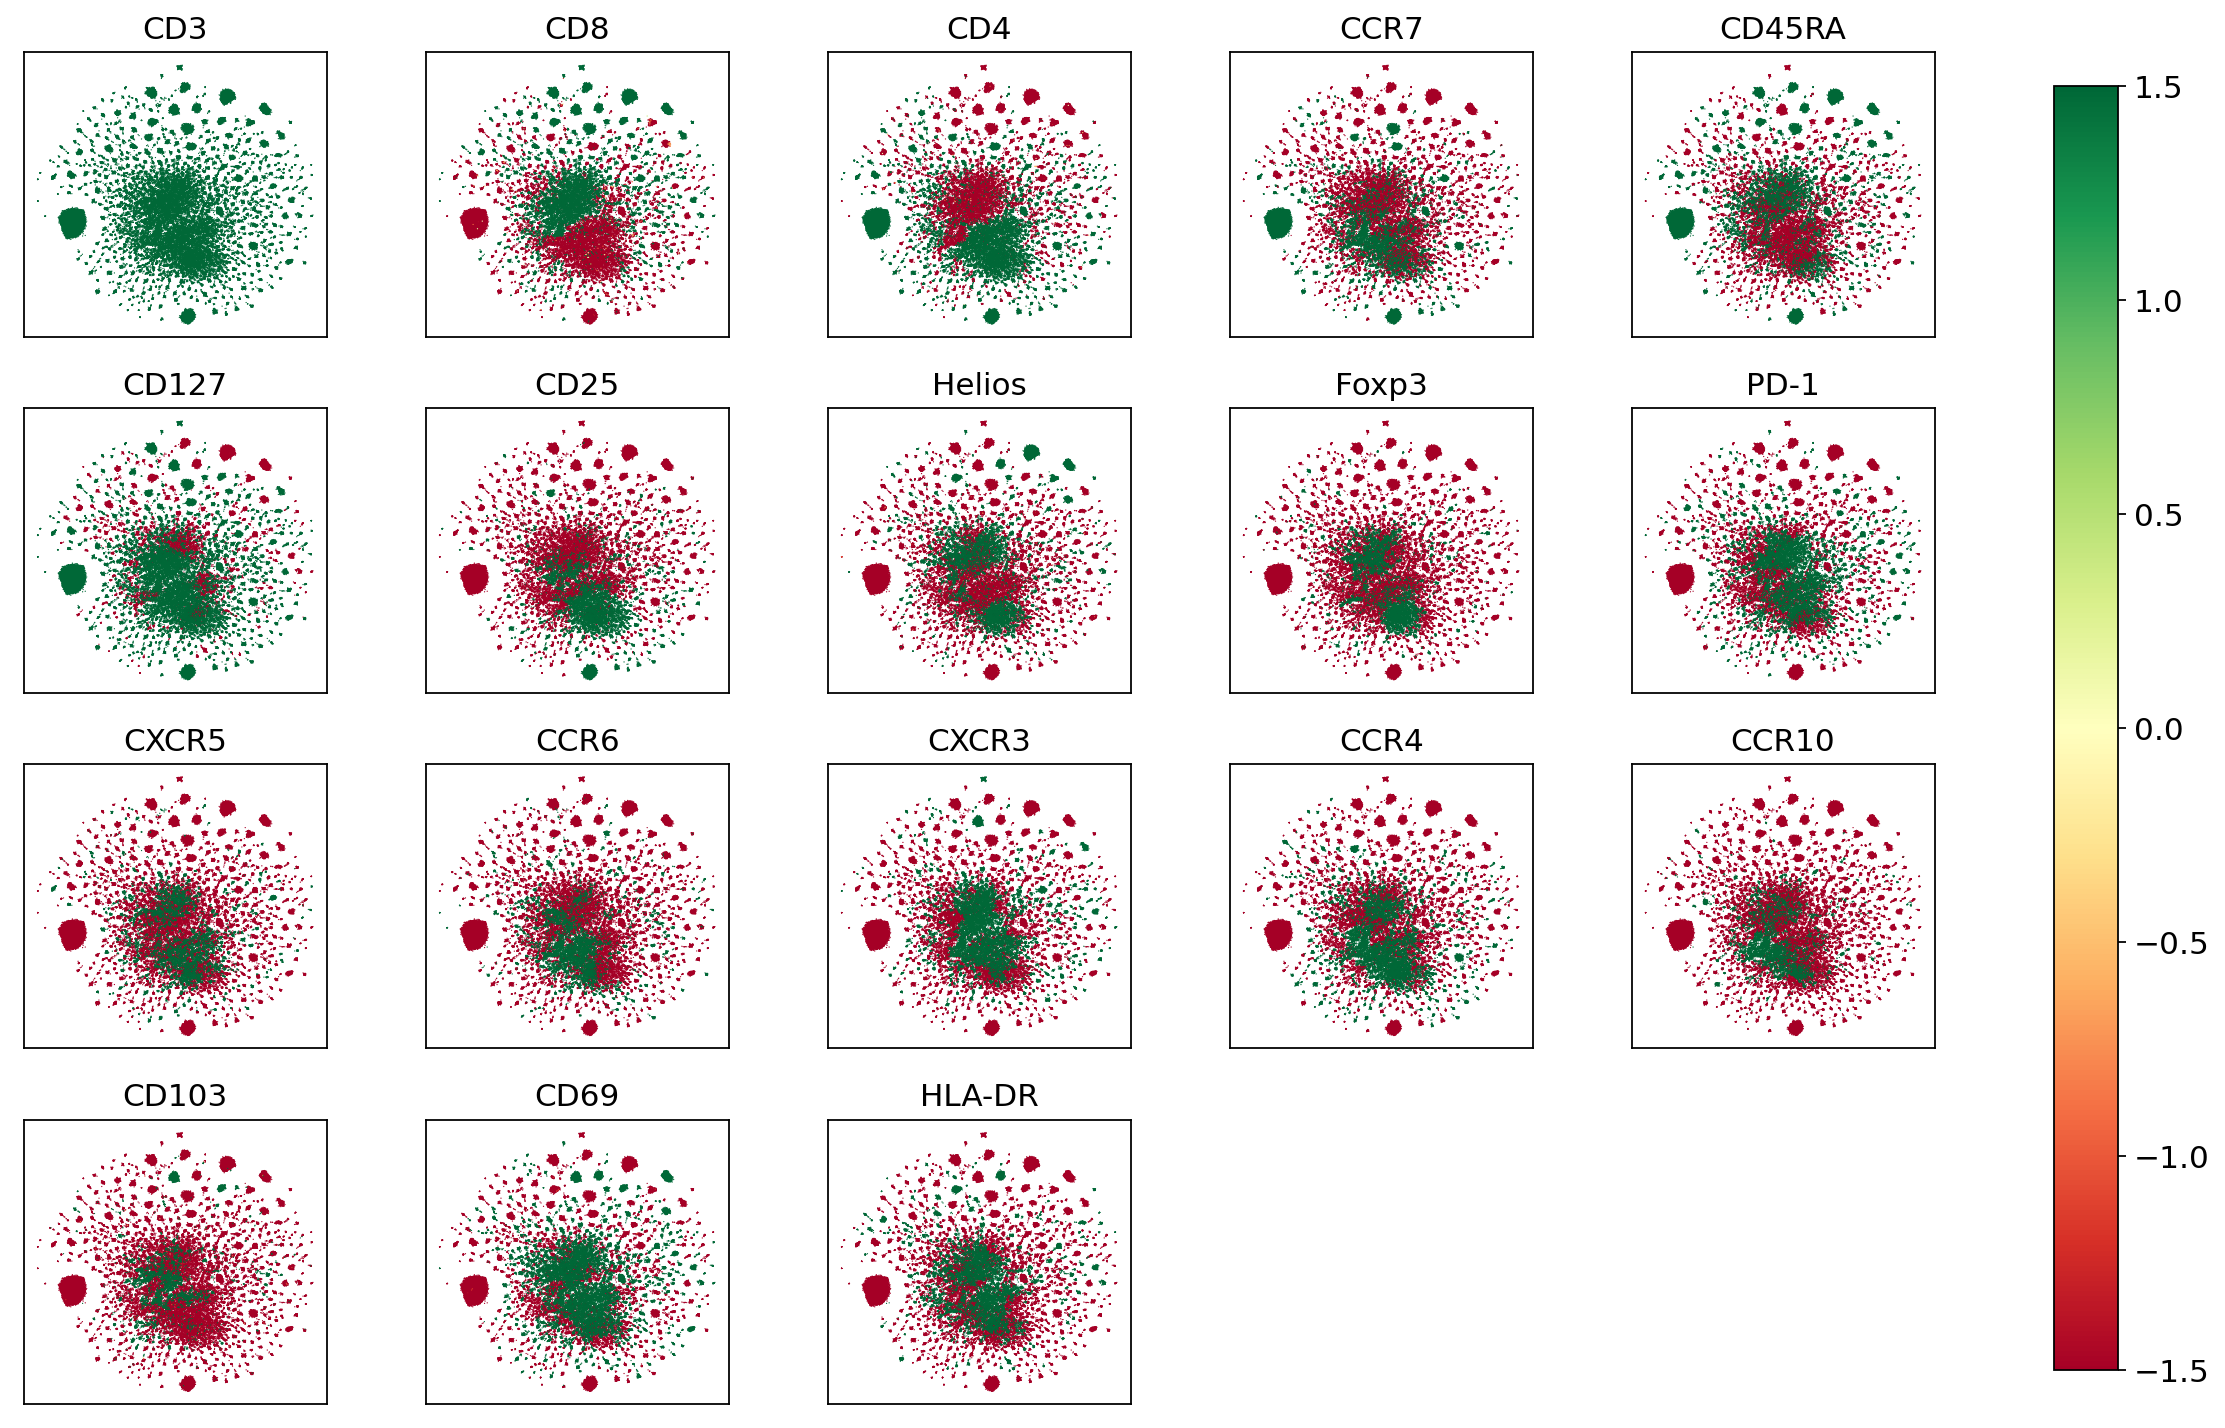

In [12]:
fig = plot_umap(dataset, color=dataset.var.index, ncols=5, return_fig=True,
                color_map='RdYlGn',vmin=-1.5,vmax=1.5)

for ax in fig.axes :
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    if ax.collections[0].colorbar != None :
        ax.collections[0].colorbar.remove()

fig.colorbar(fig.axes[0].collections[0], ax=fig.axes, shrink=0.95)
fig.set_size_inches((19,10))

In [13]:
################################################# clustering
leiden(dataset)

running Leiden clustering
    finished: found 246 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:09)


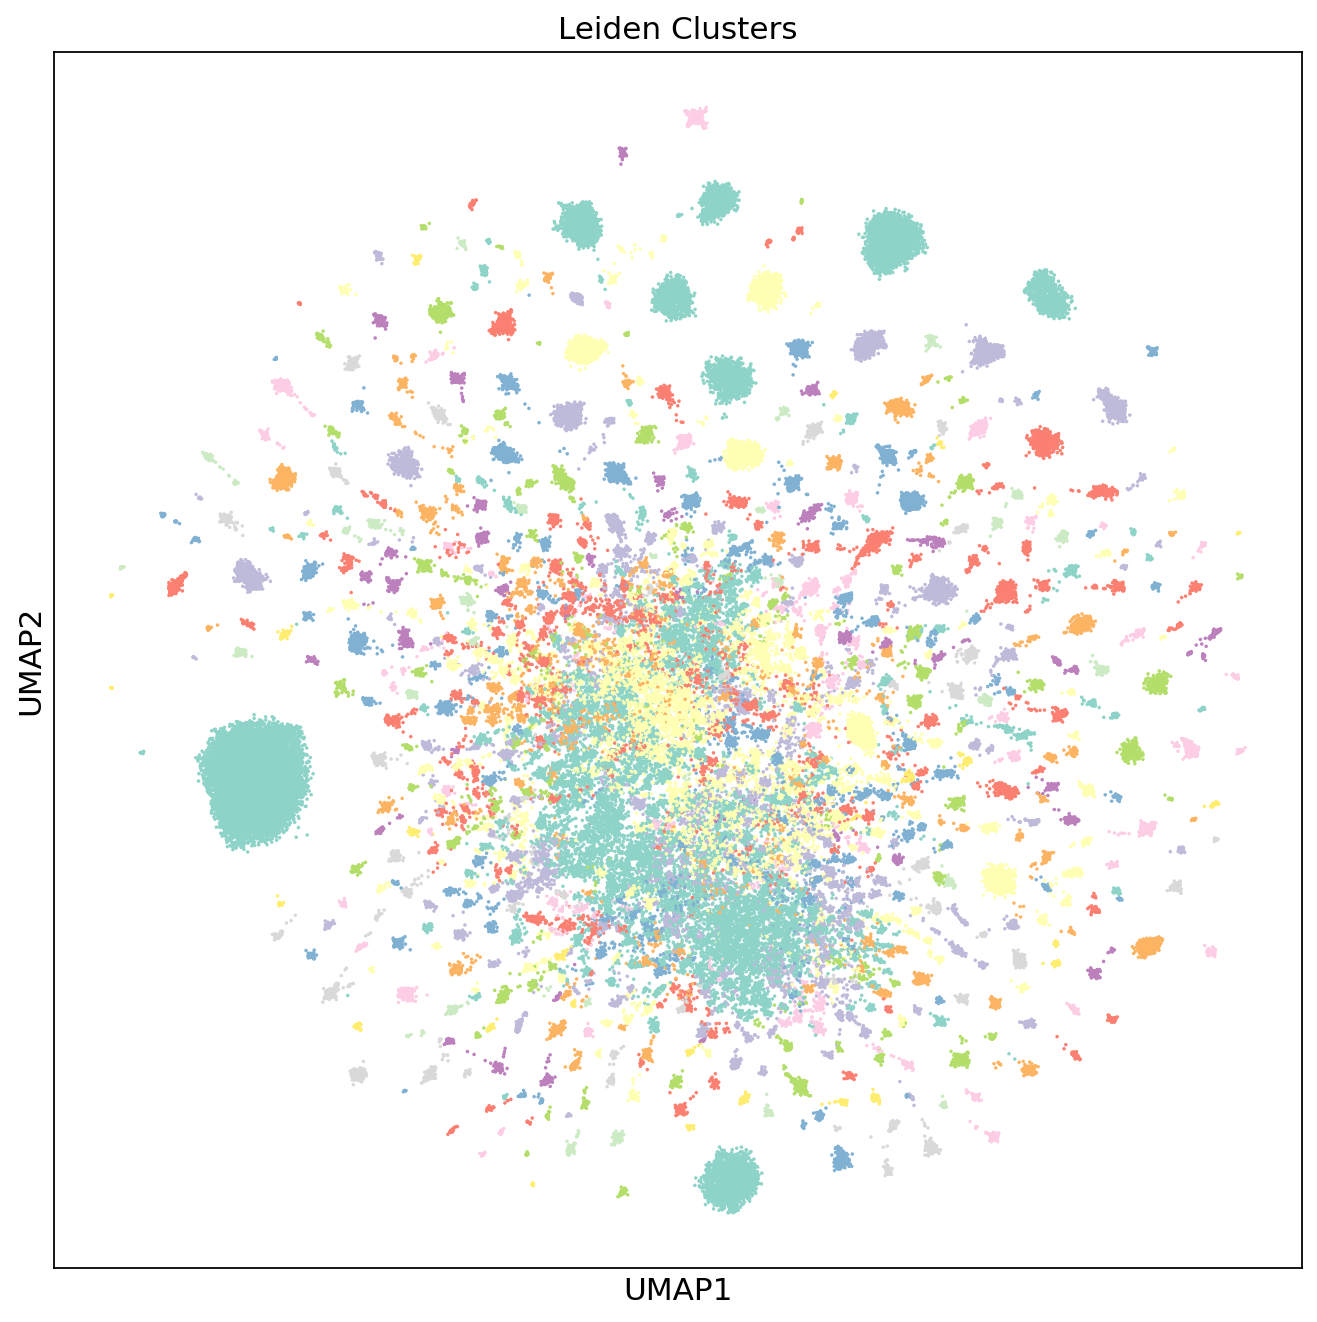

In [14]:
fig = plot_umap(dataset, color='leiden', title='Leiden Clusters',
                palette='Set3',return_fig=True, size=10)

ax = fig.axes[0].get_legend().remove()
fig.set_size_inches((10,10))

In [ ]:
# fig = figure(figsize=(15,30))
# data = dataset.obs.join(
#     DataFrame(dataset.X, index=dataset.obs.index,
#               columns=dataset.var.index))

# n_channels = len(dataset.var.index)
# for i,channel in enumerate(dataset.var.index) :
#     ax = subplot(n_channels,1,i+1)
    
#     violinplot(x='leiden', y=channel, data=data,
#                scale='width',inner=None, color='gray',linewidth=3)
    
#     for element in ax.get_children():
#         if isinstance(element,PolyCollection):
#             path, = element.get_paths()
            
#             vertices = path.vertices[path.vertices[:,1]>0]
#             ax.add_collection(PolyCollection(vertices[None,...],facecolor='green',alpha=0.25))
            
#             vertices = path.vertices[path.vertices[:,1]<0]
#             ax.add_collection(PolyCollection(vertices[None,...],facecolor='red',alpha=0.25))
    
#     ax.yaxis.tick_right()
#     xlabel('Leiden Cluster')

#     ylim(-2.5,2.5)
#     ax.grid(False)

# fig.subplots_adjust(hspace=0)
# ax.get_shared_x_axes().join(*fig.axes)
# setp([ ax.get_xticklabels() for ax in fig.axes[:-1]], visible=False);

/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


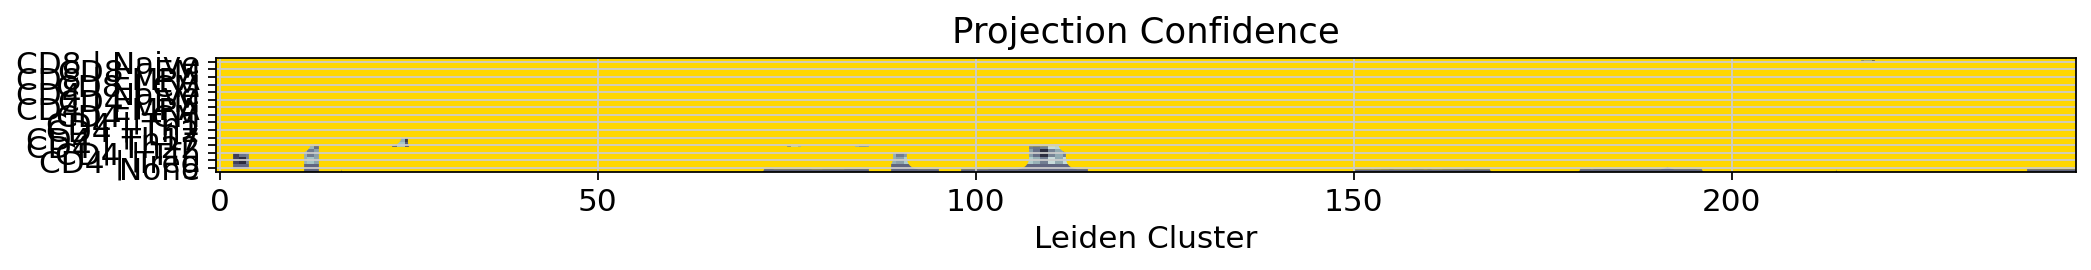

In [15]:
profile_names = [
    'CD8 | Naive', 'CD8 | EM', 'CD8 | EMRA', 'CD8 | CM',
    'CD4 | Naive', 'CD4 | EM', 'CD4 | EMRA', 'CD4 | CM',

    'CD4 | Th1', 'CD4 | Th2', 'CD4 | Th17', 'CD4 | Th22',
    'CD4 | Tfh', 'CD4 | Treg',
    'None'
]

profile_matrix = array([
    
    # CD3,CD8,CD4,CD45RA,CCR7    CXCR3,CCR6,CCR4,CCR10,CXCR5    CD127,CD25,Foxp3,Helios    PD-1,CD69,CD103,HLA-DR       
    [  0,  1, -1,   1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|Naive
    [  0,  1, -1,  -1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|EM
    [  0,  1, -1,   1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|EMRA
    [  0,  1, -1,  -1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|CM
    
    [  0, -1,  1,   1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Naive
    [  0, -1,  1,  -1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|EM
    [  0, -1,  1,   1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|EMRA
    [  0, -1,  1,  -1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|CM
    
    [  0, -1,  1,  -1,    0,       1,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th1
    [  0, -1,  1,  -1,    0,      -1,   -1,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th2
    [  0, -1,  1,  -1,    0,      -1,    1,   1,  -1,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th17
    [  0, -1,  1,  -1,    0,      -1,    1,   1,   1,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th22

    [  0, -1,  1,  -1,    0,       0,    0,   0,   0,    1,       0,   0,    0,    0,        1,  0,    0,    0], # CD4+|Tfh
    [  0, -1,  1,   0,    0,       0,    0,   0,   0,    0,       0,   1,    1,    1,        0,  0,    0,    0], # CD4+|Treg

    [  0,  0,  0,   0,    0,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # unmatched

])

def apply_labels(data, profile_matrix, profile_names, observation='prediction') :

    n_clusters = len(unique(data.obs.leiden.values))
    mapping_matrix = []

    for id in range(n_clusters):
        mapping_matrix += [mean(dot(data.X[data.obs.leiden == str(id)],profile_matrix.T),axis=0)]
        
    mapping_matrix = array(mapping_matrix).T
    
    figure(figsize=(15,15))
    ax = matshow(mapping_matrix,cmap='bone_r',fignum=1)
    
    yticks(range(len(profile_names)),profile_names)
    ax.axes.xaxis.set_ticks_position('bottom')
    
    title('Projection Confidence',fontsize=16, y =1.02)
    xlabel('Leiden Cluster')
    
    data.obs[observation] = 'None'
    for i,j in enumerate( argmax(mapping_matrix,axis=0)) :
        
        if mapping_matrix[j,i] > 3 :
            scatter(i,j,color='gold',marker="s",s=1000,linewidths=10,facecolors='none')
            data.obs[observation][data.obs.leiden==str(i)] = profile_names[j]
        else :
            scatter(i,len(profile_names)-1,color='navy',marker="s",s=1000,linewidths=10,facecolors='none')
        
apply_labels(dataset, profile_matrix, profile_names)
dataset.obs.prediction = dataset.obs.prediction.astype('category')
predictions = dataset.obs.prediction.unique()

AttributeError: 'Series' object has no attribute 'label'

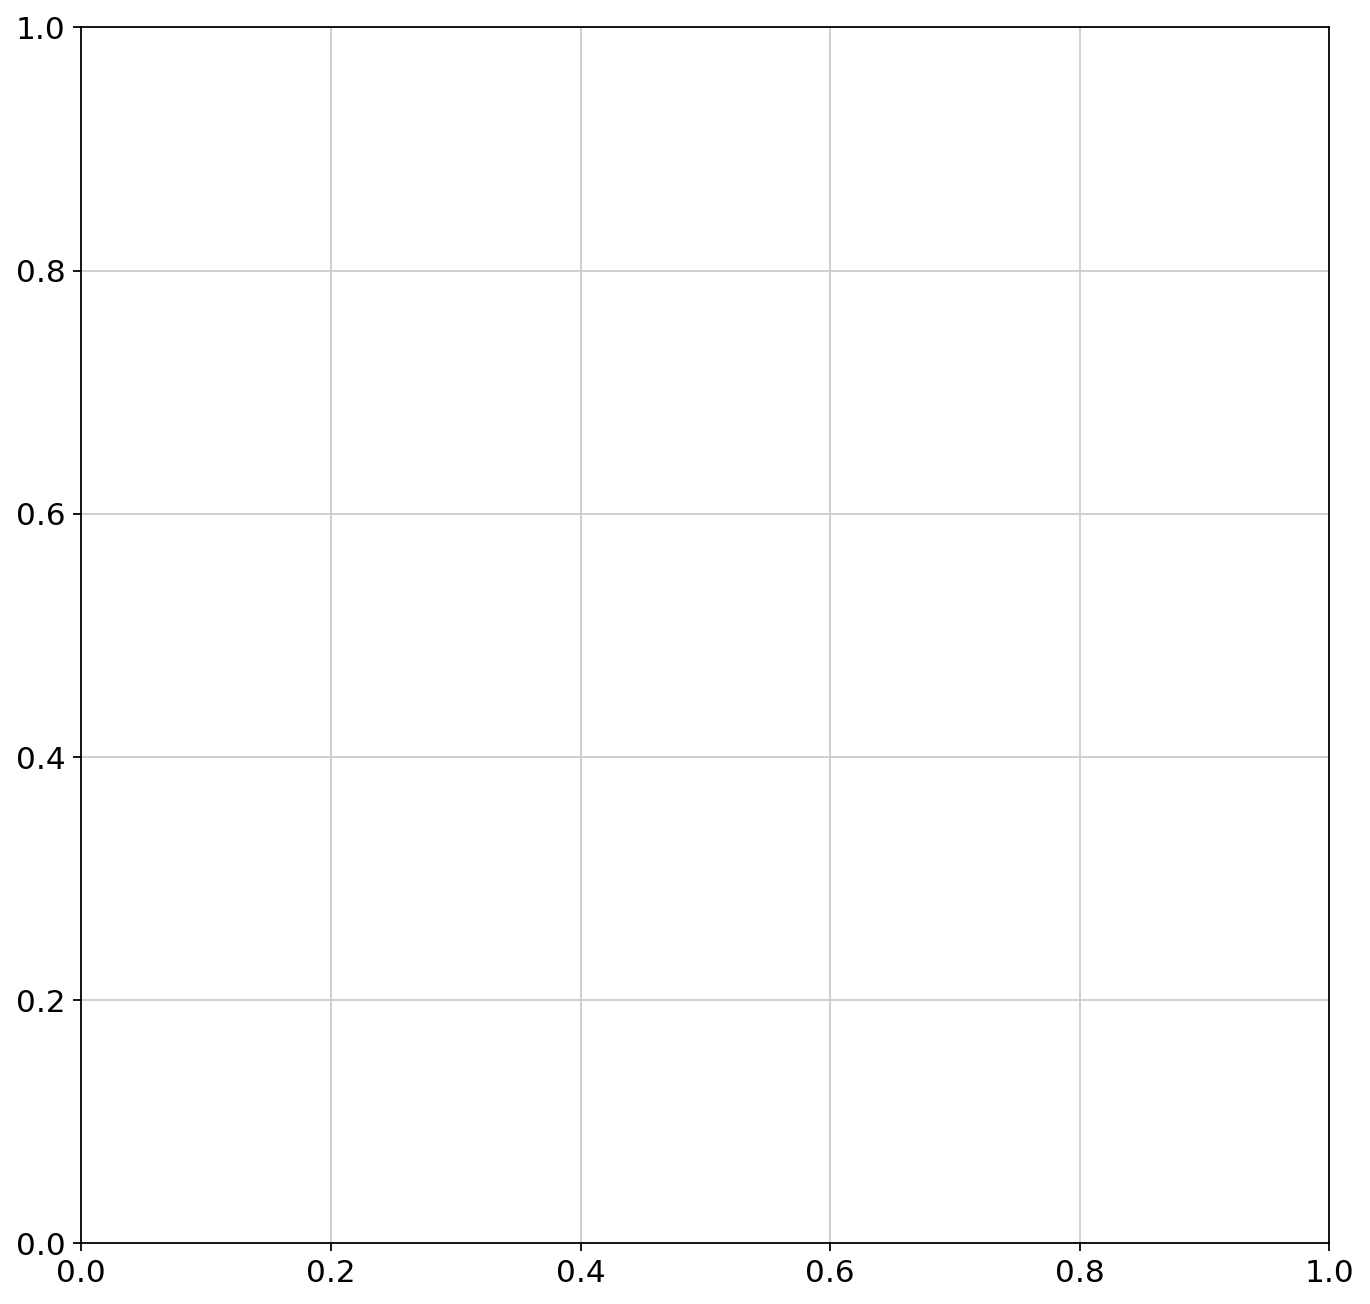

In [16]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
labels = list(sort(labels))

M = array([ dataset.obs.set_index('prediction').apply(
    lambda x : label in x.label, axis=1 ).groupby('prediction').sum().reindex(labels).fillna(0)
for label in labels ])

ax.matshow(M,cmap='bone_r',vmax=10000)

for (i, j), z in ndenumerate(M):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', color='white')

ax.xaxis.set_label_position('top') 
ax.set_xticklabels(['']+labels,rotation=90)
ax.set_yticklabels(['']+labels)

ax.set_xlabel('Prediction',fontsize=16)
ax.set_ylabel('Human Label',fontsize=16)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

In [182]:
figure(figsize=(50,50))

data = dataset.obs.join(
    DataFrame(dataset.X, index=dataset.obs.index,
              columns=dataset.var.index))

data['agreement'] = False
data['agreement'].loc[data.prediction.astype(str) in data.label.astype(str)] = True

mask = (data.label=='CD4+|Th2')
g = pairplot(data[mask], markers='.', palette={False:'red',True:'green'},
         plot_kws=dict(s=3, edgecolor=None), hue='agreement',

         y_vars=['CD8','CCR7','CCR6','CCR4','CD127','Helios','CXCR5'],
         x_vars=['CD4','CD45RA','CXCR3','CCR10','CD25','Foxp3','PD-1'])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

<Figure size 3600x3600 with 0 Axes>

In [ ]:
############################################################# dimensionally reduced per tissue and cluster
fig = figure(figsize=(17,8))
fig.suptitle('Uniform Manifold Approximation Projection',x=0.55,y=1.02)
[projection],_ = _get_data_points( annotated_dataset, 'umap', '2d', None, None, None )

for i,tissue in enumerate(tissues) :
    
    subplot(2,4,i+1)
    title(tissue,fontsize=16,y=1.02)

    lines = []
    for prediction in predictions :
        mask = (annotated_dataset.obs.prediction==prediction)&(annotated_dataset.obs.tissue==tissue)
        
        points = projection[mask]
        if prediction == 'Unmatched' :
            line, = plot(points[:,0],points[:,1],'.',ms=1,label=prediction, color='lightgray',zorder=-1)
        else :
            line, = plot(points[:,0],points[:,1],'.',ms=1,label=prediction)

        xticks([], []); yticks([], [])
        lines += [line]
        
        
figlegend( lines, predictions, loc = (0.1,0.01), ncol=6,
          fontsize=16, markerscale=10, frameon=False);